In [ ]:
!pip install networkx

# 1. [단어1, 단어2, 빈도수] 로 데이터프레임 전처리하기
# 2. 동시출현 빈도계산 -> 저장 -> 네트워크 시도 2 

차례대로 실행하면 됨

참고
*  
https://foreverhappiness.tistory.com/38
*  
https://blog.daum.net/geoscience/1408

# 라이브러리

In [136]:
import networkx as nx
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import operator
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import platform
from pandas._libs import parsers

In [ ]:
# 한글 폰트 설정

if (platform.system() == 'Windows'):
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='AppleGothic')

# 한글 폰트
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumBarunGothic


# 전처리

In [151]:
raw = pd.read_csv('/content/den_wan.csv',encoding='utf-8-sig')
#df.columns = ['키워드','개수']
#df = df.drop(['Unnamed: 0, Unnamed: 0.1'], axis=1)
df = raw.dropna()
df.head()

,Unnamed: 0,Unnamed: 0.1,본문,날짜,리트윗,하트,all_tokens,tokens,nouns
0,0,0,병원에 가야 할 거 같은데 그냥 집 앞 내과 가서 항염 제 달라고 하면 되는 건지 ...,2022년 5월 5일,0,0,"['병원', '아야', '은데', '그냥', '아서', '라고', 'ㄴ지', '아무...","['병원', '달다', '아무래도', '잇몸', '문제', '맞다', '귀가', '...","['병원', '잇몸', '문제', '귀가', '이비인후과']"
1,1,1,나의 해 기르 전해 들은 친구들은 세 명이 캠핑 느낌 쇼핑 재선거 호기심 파주 시작...,2022년 5월 5일,0,0,"['기르', '전하', '친구', '캠핑', '느낌', '쇼핑', '선거', '호기...","['기르다', '친구', '캠핑', '느낌', '쇼핑', '선거', '호기심', '...","['친구', '캠핑', '느낌', '쇼핑', '선거', '호기심', '파주', '시..."
2,2,2,앞니 두 톨 안 보이는 김에 궁금증 나 과연 제현이는 유치 빠질 때 울었을까 안 울...,2022년 5월 5일,4,9,"['앞니', '보이', '궁금증', '과연', '제현', '유치', '빠지', '을...","['앞니', '궁금증', '과연', '유치', '빠지다', '울다', '울다', '...","['앞니', '궁금증', '유치', '부모']"
3,3,3,정말 실례지만 한 가지 여쭤볼 게 있는데 요혹시 베타 신가요 채굴 팀 사람은 그렇다...,2022년 5월 5일,0,1,"['정말', '실례', '지만', '가지', '여쭈', '는데', '혹시', '베타...","['실례', '가요', '채굴', '대답', '성별', '형질', '치료', '다르...","['실례', '가요', '채굴', '대답', '성별', '형질', '치료', '화학..."
4,4,4,학교 다닐 때도 그런 경우를 본 적이 있었다 너무 잘나서 남들이 다 피해 주는 그런...,2022년 5월 5일,0,0,"['학교', '다니', '그런', '경우', '너무', '잘나', '아서', '피해...","['학교', '피해', '오후', '예약', '환자', '도망치다', '깨닫다']","['학교', '피해', '오후', '예약', '환자']"


In [152]:
# 리스트가 문자열로 저장된 경우 (ex> ["['dd','aa']"])
word_list = []

for i in df['tokens']:
  i = ast.literal_eval(i)
  word_list.append(i)

In [ ]:
word_list

In [154]:
# 트위터 릴레이 문답식 트윗 제거(ex>내가 아파본 경험 : 충치O, 폐렴X ,,,)
for word in word_list:
    if '골절' in word and '폐렴' in word:
      word.clear()

In [155]:
# 특정 단어가 들어가는 리스트 제거 
# ex> ['잇몸','마르다'] -> []
for word in word_list:
    if '만개' in word:
      word.clear()
    if '미소' in word:
      word.clear()
    if '마르다' in word or '마름' in word or '말라' in word or '건성' in word or '사막' in word or '말라가' in word or '메마르다' in word:
      word.clear()
    if '야구' in word or '야구단' in word:
      word.clear()

In [156]:
stopwords = ['르', '과', '까지', '곳', '다시금', '제현', '귀엽다', '과', '게', '때','쿠','스트라빈스키','존','사분','김현정','머지않아','팅팅','흑흑','조속히','새끼','미친년','미친놈','개새끼',
             '링','보다','경우','반면','되다','있다','자나','살다','혹시','경우','때문','정도','사항','세진','보라','다세','건희','윤호','이재명',
                   '해당','겁니다','이것','저것','그것','돋움','신명', '태명', '이미', '돋움','같이','우짜다','어떡하다','제대로',
                   '동안','거기','저기','여기','대부분','누구','무엇','고딕','만큼','굴림','감사','건지','텐데',
                   '안녕','그렇다','이번','걸로','수고','겁니까','그간','그건','그때','글쓴이','누가','니다','다면','쪼르르','세계인',
                   '뭔가','또한','하다','이다','되다','다능','자다','자체','서체','지나가다','잇다','같다','미치','있다','없다', '여지','관련',
                   '생각', '현재', '진행', '사람', '마음', '남산', '내용', '현실','음','막','전하다','들다','열다',
                   '두다','서다','산하','지금','주변','대상','부분','요즘','하루','마련','시간','이상','행위','고검','야마다','검찰','하루하루','우우','엄밀히','순전히','토니오','술술','몹시','영수','이전',
                   '이하','바로 가기','바로가기','제가','먹다','보이다','지나다','콜론','각','대하다','따르다','인하다','전','후','예','한','다','보다','그렇다','좋다',
                   '나다','너무','정말','내다','많다','그리다','물론','조금','다시','느끼다','없이','특히','여러','다른','이런','가지다','어떻다','통하다', '위하다','그러다','위하다',
                   '다니다','나서다','들다','열다','어떻게','막상','가다','오다','말다','계속','쉬다','혜량','인디','망개','제법','세기',
                   '무현','여쭈다','베타','되묻다','뜨다', '다녀오다','서녀','붙다','찾다','생각나다','앉다','바니','이르다','크다',
                   '그냥','그저','바로','시키다','허다','내내','해량','걸다', '이렇다','이렇게','켜다','어린이날','그날','남주','제일','지금껏',
             '진짜','끌다','받다','넣다','무지','태주','아무튼','알다','틀다','마치','부리','익히다','만들다','잡다','아주','영재','대구','서울','매우','나오다',
             '뫄다','케이','히나','이치','경허','비다','찌다','받다','나가다','일어나다','오키','일단','우왕','드리다','큰애',
             '대다','덮다','바잔','스다','들어가다','놓아두다','놓다','틀다','들다','사다','팔다','이대로','서교동','조지','치다','그다음','다음',
             '마티','파주시','태평','잘나다','모르다','알다','알고있다','주전','작대기','아이스','들뜨다','푸다','아우','쿠쿠','가장','몰다','뭐하다', '눕다', '누르다','하하','냅다',
             '존나','데리다','트다','쓰다','타임','라인','벌리다','타다','이제','위하다','다니다','한동안','저번','마이','어쩌다','사실','그렇게','이렇게',
             '해보다','해저','가세','시마','블루','부르다','야지', '아무래도', '맞다','파주','동해','랜드','스타','검찰','가요','형질','우현',
             '과연','연하다','남자친구','한번','끌어들이다','이날','코난','전혀','최소한','그나저나','레알','님프','테너',
             '연월일','동시','문인','민사','당부','모습','바라보다','경애','총비서','동지','모읍','군호','개키다','양치식물','불쑥불쑥','드래건','논란거리','나나미','버크','애니','갑바','요지경','힐러','임화','실로',
             '들리다','리츠','달랑달랑','갈수록','크윽','겟다','이따가','프리','오리','두둥실','한마음','분뇨','조다','뽀짝','하마터면','밀다','카다','한쪽','낙도','자기','아장거리다','주도','출처','현이',
             '우현','우현이','꿈꾸다','순간','갑자기','히다','분명','중생', '근데','레즈','드르르','집어넣다',
             '보통','심의','결정','이유','근처','평점','리뷰','세븐틴','제페','니즈','멜론','혹시나','대충','순응','종종','많이','외려','얼마나','이리저리','돌리다','시간부','곁들이다',
             '부풀다','금의환향','하인','의원','위장','광인','제외','바이','고인','고래','모험','스트','레스','왠지','매번','나타나다',
             '아오키','가자','데다','어린이','나눠주다','개업','괜히','나머지','최선','이것저것','바라다','바다','다가가다','가시다','최인섭','쓰이다','사리탑','엘리엇',
             '사라','정작','얘기','발전','얼마','공산당','일수','만나다','감싸다','누르다','그제서야','태용이','유투','현진','아마','가만히','그린란드','요하다','황두','맘대로','이후','착실히','난초','저렇게','이렇게',
             '트로','옛날이야기','온종일','왕비','웃어른', '장모','지폐','진실로','촛불','통역','가스','라이팅','르네','집어넣다','드르르르','르네',
             '표시','구라','진실로','저울','어쨌든','난무','어영부영','하하','르네', '냅다','와중','피카','깨닫다','디다','너와', '김선호', '황두', '김래원','연초', '오가타','금상첨화','가을비','손안','하나',
             '새끼','잡거','베리','딜리','갈래','진짜로','날아오다','날아가다','인가','역시','갯마을','차차차','두식','주술','회전','시발','아안','하도','왜냐하면','타츠미','루씨','메루','시안','젤로',
             '잠시만','아직','비바','응수','강동원','로드','데이브','기실','일주','하여튼','컴백','디비','며칠','졸리','라리','섹트','청주','어서','요시','점심때','이따','가치','새끼','여하튼','너도나도',
             '레알','마타','에그','바자','지랄','리사','저벅저벅','아까','서화','시방','사모','나다니다','호시','아월','팔룡','슬쩍','슬그머니','퀴어','위터','포커','조슈야','가요','승관','디노','만납다','꾸리',
             '에스','쿱스','맛나','드디어','굳이','이제껏','이리','이제서야','혁이','현아','이따','비록','설마','자꾸','호주','어느새','언제','에리히','화중','업태','에이치','박박','오가타','모토','반드시',
             '민규','가령','언제','졸라','레트','리버','이쁜이','재영','트라이','김혜은','다우지','스톤','그리니치','김균','플레','지니','민수','버블','원우','입면','라라','선생','부천','현진이','근년','그룹웨어','시방',
             '사바','기철','위즈','파크','한곳','들어오다','기승','강남구','개포동','논현동','임대','개원','어젯밤','거상','베리','라덴','무조건','닷새','국극','개다','세내다','냉큼','브리','루트','한몫',
             '오자','엠피','스리','날로','러스','하마','시어터','트리','솔직히','제발','세상','대뜸','혹은','어쩌면','엄청','아무것','모에','사마','부리다','갈다','브이','로그','갖다','묻히다','에디','추스르다','뚝딱','옛날',
             '수없이','아직','테라','안네','스톱','최진욱','루프','쏘다','서불','지현','캐시','그대로','라프','또는','내면','이제서야','여전히','한인','성우','레이','위풍당당','범이','임영웅','대체','도저히','구구구',
             '논현동','매트','자파','쥐불놀이','심지어','돌아오다','낟다','시발','얼떨결','후욱','양재','충주','복합','로컬','타일','수수','최고','아직','아까','기하다','치가','그럭적럭','하필','주기','난생처음','여태','대체',
             '엮다','짓다','주무','세요','엉엉','살짝','넘다','요부','어찌나','어쩌다','무려','앞날','놔주다','고야','굉장히','선천','앞쪽','가리다','아래','결국','의하다']
#stopwords_set = set(stopwords)


In [157]:
# 빈도수 기준으로 단어 제거 위함(트위터_자연어처리_함수.ipynb 에서 만든 워드카운트 파일 기준)
count = pd.read_csv('/content/치과_count.csv',encoding='cp949',header=None, names=['keyword','count'], index_col=False)
count = count[count['count'] >= 40]  # 빈도수 40개 이상
count_list = list(count['keyword'])
len(count_list)

295

In [158]:

cleared_list = []
li_1 = []
li_2 = []
list1 = []

# 불용어(stopwords)에 해당하는 요소 제외 -> list1
for word in word_list:
    li_1 = []
    for w in word:
        if w not in stopwords:
           li_1.append(w)
    list1.append(li_1)

# 빈도수 기준(count_list) 충족하는 요소 추출 -> cleared_list
for li in list1:
    li_2 = []
    for l in li:
        if l in count_list:
            li_2.append(l)
    cleared_list.append(li_2)

In [159]:
cleared_list

[['병원', '달다', '잇몸', '문제', '아프다', '이비인후과'],
 ['친구', '느낌', '시작', '대기'],
 ['앞니', '유치', '빠지다', '울다', '울다', '뽑다', '뽑다'],
 ['치료', '다르다', '웃다'],
 ['학교', '오후', '예약', '환자'],
 ['시험', '끝나다', '예약'],
 ['물어보다'],
 ['아기'],
 ['오늘'],
 ['의사', '당장', '붓다'],
 [],
 [],
 ['무섭다', '혼자', '공포', '영화'],
 ['수술', '검진', '일정', '필요'],
 ['병원'],
 ['어제'],
 ['이름', '웃기다', '죽다'],
 ['준비'],
 ['눈물', '뽑다', '싫다'],
 ['아프다'],
 ['거지'],
 ['병원'],
 ['내일', '싫다'],
 ['남자'],
 [],
 ['싫다', '싫다', '싫다', '싫다', '싫다'],
 ['점심'],
 ['싫어하다'],
 [],
 ['싫다'],
 ['싫다'],
 ['아프다', '아프다', '의사', '기억'],
 ['앞니', '빠지다', '남다'],
 ['아프다', '무섭다'],
 [],
 ['아기', '데려가다', '고민'],
 [],
 ['오늘', '사랑니', '빼다', '마시다', '전화', '듣다', '전화'],
 ['문제', '생기다', '예쁘다', '사진', '웃다', '빼다', '일찍', '교정', '엄마', '조지다'],
 ['의사', '당장', '붓다'],
 ['오래', '걸리다'],
 ['무섭다', '문제', '빨다'],
 ['진료'],
 [],
 ['돈가스', '데려가다'],
 ['미치다', '오늘'],
 ['예약', '묻다', '이름'],
 ['엄마', '치료', '약속', '얼굴', '웃다'],
 ['아이', '싫다', '고민'],
 ['싫다', '싫다', '싫다'],
 [],
 [],
 ['얼굴', '사진', '작다', '빼다', '얼굴', '빼다'],
 [],
 [],
 [],
 [],
 ['오늘', '

In [160]:
df['cleared_token'] = cleared_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [161]:
df

,Unnamed: 0,Unnamed: 0.1,본문,날짜,리트윗,하트,all_tokens,tokens,nouns,cleared_token
0,0,0,병원에 가야 할 거 같은데 그냥 집 앞 내과 가서 항염 제 달라고 하면 되는 건지 ...,2022년 5월 5일,0,0,"['병원', '아야', '은데', '그냥', '아서', '라고', 'ㄴ지', '아무...","['병원', '달다', '아무래도', '잇몸', '문제', '맞다', '귀가', '...","['병원', '잇몸', '문제', '귀가', '이비인후과']","[병원, 달다, 잇몸, 문제, 아프다, 이비인후과]"
1,1,1,나의 해 기르 전해 들은 친구들은 세 명이 캠핑 느낌 쇼핑 재선거 호기심 파주 시작...,2022년 5월 5일,0,0,"['기르', '전하', '친구', '캠핑', '느낌', '쇼핑', '선거', '호기...","['기르다', '친구', '캠핑', '느낌', '쇼핑', '선거', '호기심', '...","['친구', '캠핑', '느낌', '쇼핑', '선거', '호기심', '파주', '시...","[친구, 느낌, 시작, 대기]"
2,2,2,앞니 두 톨 안 보이는 김에 궁금증 나 과연 제현이는 유치 빠질 때 울었을까 안 울...,2022년 5월 5일,4,9,"['앞니', '보이', '궁금증', '과연', '제현', '유치', '빠지', '을...","['앞니', '궁금증', '과연', '유치', '빠지다', '울다', '울다', '...","['앞니', '궁금증', '유치', '부모']","[앞니, 유치, 빠지다, 울다, 울다, 뽑다, 뽑다]"
3,3,3,정말 실례지만 한 가지 여쭤볼 게 있는데 요혹시 베타 신가요 채굴 팀 사람은 그렇다...,2022년 5월 5일,0,1,"['정말', '실례', '지만', '가지', '여쭈', '는데', '혹시', '베타...","['실례', '가요', '채굴', '대답', '성별', '형질', '치료', '다르...","['실례', '가요', '채굴', '대답', '성별', '형질', '치료', '화학...","[치료, 다르다, 웃다]"
4,4,4,학교 다닐 때도 그런 경우를 본 적이 있었다 너무 잘나서 남들이 다 피해 주는 그런...,2022년 5월 5일,0,0,"['학교', '다니', '그런', '경우', '너무', '잘나', '아서', '피해...","['학교', '피해', '오후', '예약', '환자', '도망치다', '깨닫다']","['학교', '피해', '오후', '예약', '환자']","[학교, 오후, 예약, 환자]"
...,...,...,...,...,...,...,...,...,...,...
14167,14167,14167,희재 브금에 치과 얘기한다,2022년 3월 26일,0,0,"['치과', '얘기', 'ㄴ다']","['희다', '얘기']",['얘기'],[]
14168,14168,14168,현진이 진짜 귀여운 점 치과 같다고 하면 치과 상황극 해주고 라디오 같다고 하면 라...,2022년 3월 26일,0,2,"['현진', '진짜', '귀엽', '치과', '다고', '치과', '상황', '라디...","['현진', '상황', '라디오', '라디오', '상황']","['현진', '상황', '라디오', '라디오', '상황']",[]
14169,14169,14169,치과 안 무서워하는 황은 신기하다 역시 사람보다 귀신을 무서워할 거 같은 사람,2022년 3월 26일,0,0,"['치과', '무서워하', '신기', '역시', '사람', '보다', '귀신', '...","['무서워하다', '역시', '귀신', '무서워하다']",['귀신'],"[무서워하다, 무서워하다]"
14170,14170,14170,전동 면도기 누가 치과 같다니까 냅다 상황극 해줌 와중에 가글하고 오세요 이거 현실...,2022년 3월 26일,5,4,"['전동', '면도기', '누구', '치과', '다니까', '냅다', '상황', '...","['전동', '면도기', '냅다', '상황', '와중', '가글', '고증', '미...","['전동', '면도기', '상황', '와중', '가글', '고증']",[미치다]


In [163]:
df.to_csv('/content/네트워크만들꺼.csv',encoding = 'utf-8-sig')

# 동시 출현 빈도 계산

In [ ]:
# 동시 출현 빈도
count = {}

for context in word_list:
    #print(context)
    for i, a in enumerate(context):
        for b in context[i+1:]:
            if a>b:
                count[b,a] = count.get((b,a),0) + 1
            else:
                count[a,b] = count.get((a,b),0) + 1

count = {key: value for key, value in count.items() if key[0] != key[1]}

## 빈도 통계값 계산
생략가능

In [ ]:
# 발생 빈도 통계값 계산 위해서 sum변수, 리스트 생성
s = 0   # value들의 합
v = []  # count의 value값만 추출
for value in count.values():   
  v.append(value)
  s += value

<BarContainer object of 106 artists>

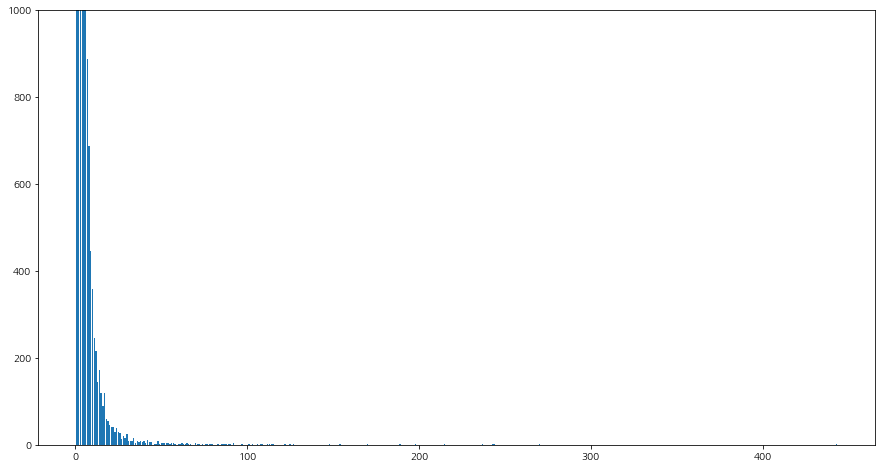

In [ ]:
xaxis = np.unique(v).tolist() #unique한 value list
yaxis = []                    #각 value의 개수
for xaxi in xaxis:
  yaxis.append(v.count(xaxi))

plt.figure(figsize=(15,8))
#plt.xticks(xaxis, size ='1')
plt.ylim(0,1000)
plt.bar(xaxis, yaxis)

In [ ]:
print('단어 동시출현 빈도의 평균 : {0}회'.format(s/len(count)))
print('단어 동시출현 빈도의 평균 : {0}회'.format(np.median(v)))

단어 동시출현 빈도의 평균 : 1.4458472785052159회
단어 동시출현 빈도의 평균 : 1.0회


In [ ]:
# 빈도 1~5 제거 후 계산
count = {key : value for key, value in count.items() if value >5}

s = 0
v = []
for value in count.values():
  v.append(value)
  s += value

print('단어 동시출현 빈도의 평균 : {0}회'.format(s/len(count)))
print('단어 동시출현 빈도의 중앙값 : {0}회'.format(np.median(v)))

단어 동시출현 빈도의 평균 : 11.649319317594347회
단어 동시출현 빈도의 중앙값 : 8.0회


* 최종 추출

In [ ]:
count.get(("a", "b"),0) #a, b라는 key가 없을 때는 디폴트를 0으로 해라 

# value가 15이상인 것만 추출
count = {key : value for key, value in count.items() if value >= 10}
count

{('병원', '잇몸'): 20,
 ('문제', '병원'): 17,
 ('맞다', '병원'): 30,
 ('병원', '아프다'): 87,
 ('병원', '이비인후과'): 14,
 ('맞다', '잇몸'): 11,
 ('아프다', '잇몸'): 101,
 ('문제', '아프다'): 19,
 ('맞다', '아프다'): 51,
 ('아프다', '이비인후과'): 13,
 ('뽑다', '앞니'): 10,
 ('빠지다', '유치'): 23,
 ('뽑다', '유치'): 19,
 ('빠지다', '울다'): 10,
 ('빠지다', '뽑다'): 13,
 ('뽑다', '울다'): 20,
 ('예약', '오후'): 14,
 ('예약', '환자'): 20,
 ('끝나다', '시험'): 41,
 ('끝나다', '예약'): 24,
 ('날짜', '예약'): 10,
 ('어머니', '형편'): 17,
 ('어머니', '의사'): 19,
 ('어머니', '열성'): 17,
 ('어머니', '한번'): 17,
 ('계기', '어머니'): 17,
 ('당장', '어머니'): 17,
 ('붓다', '어머니'): 17,
 ('어머니', '적금'): 17,
 ('어머니', '해약'): 17,
 ('의사', '형편'): 17,
 ('열성', '형편'): 17,
 ('한번', '형편'): 17,
 ('계기', '형편'): 17,
 ('당장', '형편'): 17,
 ('붓다', '형편'): 17,
 ('적금', '형편'): 17,
 ('해약', '형편'): 17,
 ('열성', '의사'): 17,
 ('의사', '한번'): 23,
 ('계기', '의사'): 17,
 ('당장', '의사'): 21,
 ('붓다', '의사'): 19,
 ('의사', '적금'): 17,
 ('의사', '해약'): 17,
 ('열성', '한번'): 17,
 ('계기', '열성'): 17,
 ('당장', '열성'): 17,
 ('붓다', '열성'): 17,
 ('열성', '적금'): 17,
 ('열성', '해약'): 17,
 ('계기

## 저장

In [ ]:
df=pd.DataFrame.from_dict(count, orient='index')
df['keyword'] = df.index
df.reset_index(level=0, inplace= True)
df = df.drop(['index'], axis=1)
#df = df.columns(['freq', 'keyword'])
df['freq'] = df[0]
df = df.drop([0], axis=1)

In [ ]:
df.columns

Index(['keyword', 'freq'], dtype='object')

In [ ]:
print(len(df['freq']))

2123


In [ ]:
list1=[]
for i in range(len(df)):
    #index를 중심으로 계속 중첩해서 list에 넣는다 
    list1.append([df['keyword'][i][0],df['keyword'][i][1],df['freq'][i]])

df2=pd.DataFrame(list1, columns=["keyword1","keyword2","freq"]).sort_values(by=['freq'],ascending=False)

In [ ]:
print(len(df2['freq']))

In [ ]:
df.head()

,keyword,freq
0,"(병원, 아프다)",87
1,"(아프다, 잇몸)",101
2,"(선생, 아프다)",114
3,"(선생, 의사)",198
4,"(무섭다, 아프다)",125


In [ ]:
df2.head()

,keyword1,keyword2,freq
17,뽑다,사랑니,443
6,빼다,사랑니,270
9,아프다,치료,270
27,사랑니,아프다,244
22,신경,치료,243


# 네트워크 시도1 (실패)

In [ ]:
len(df2)
#len((np.where(df3['freq']>=5))[0])

1520

In [ ]:
G=nx.Graph()
for i in range(1520):
    #print(pair)
    G.add_edge(df2['keyword1'][i], df2['keyword2'][i], 
               weight=int(df2['freq'][i]))

In [ ]:
# 노드 중요도 측정
dgr = nx.degree_centrality(G)       #각 노드의 연결 수 
btw = nx.betweenness_centrality(G)  #연결 수는 적지만 중요한 노드
cls = nx.closeness_centrality(G)    #어떤 노드에서든 가깝게 접근할 수 있는 노드

In [ ]:
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
print("** degree **")
for x in range(20):
    print(sorted_dgr[x])
print("** betweenness **")
for x in range(20):
    print(sorted_btw[x])
print("** closeness **")
for x in range(20):
    print(sorted_cls[x])

** degree **
('치료', 0.32604373757455263)
('아프다', 0.294234592445328)
('오늘', 0.2823061630218688)
('사랑니', 0.22266401590457255)
('병원', 0.147117296222664)
('선생', 0.11928429423459243)
('무섭다', 0.11332007952286281)
('충치', 0.11332007952286281)
('뽑다', 0.10934393638170974)
('예약', 0.10735586481113318)
('의사', 0.09542743538767395)
('교정', 0.09542743538767395)
('잇몸', 0.08349900596421471)
('빼다', 0.08151093439363816)
('진료', 0.07952286282306162)
('내일', 0.07157057654075547)
('이빨', 0.07157057654075547)
('마취', 0.06560636182902584)
('생기다', 0.06163021868787276)
('스케일링', 0.05566600397614314)
** betweenness **
('치료', 0.19731941907988687)
('오늘', 0.17580154512541693)
('아프다', 0.15719692294067797)
('사랑니', 0.09648930518374653)
('병원', 0.0886671252303987)
('상연', 0.07815399121757678)
('많이', 0.0722749358976753)
('교정', 0.0575903808766374)
('선생', 0.057087506186891686)
('칫솔', 0.04664398343883353)
('무섭다', 0.04597937856502736)
('냄새', 0.03222506483894333)
('잇몸', 0.030582035925512396)
('예약', 0.026734545019909066)
('의사', 0.0266

In [ ]:
class MakeGraphml:
    def make_graphml(self, pair_file, graphml_file):
        out = open(graphml_file, 'w', encoding = 'utf-8-sig')
        entity = []
        e_dict = {}
        count = []
        for i in range(len(pair_file)):
            e1 = pair_file.iloc[i,0]
            e2 = pair_file.iloc[i,1]
            #frq = ((word_dict[e1], word_dict[e2]),  pair.split('\t')[2])
            frq = ((e1, e2), pair_file.iloc[i,2])
            if frq not in count: count.append(frq)   # ((a, b), frq)
            if e1 not in entity: entity.append(e1)
            if e2 not in entity: entity.append(e2)
        print('# terms: %s'% len(entity))
        #create e_dict {entity: id} from entity
        for i, w in enumerate(entity):
            e_dict[w] = i + 1 # {word: id}
        out.write(
            "<?xml version=\"1.0\" encoding=\"UTF-8\"?><graphml xmlns=\"http://graphml.graphdrawing.org/xmlns\" xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\" xsi:schemaLocation=\"http://graphml.graphdrawing.org/xmlnshttp://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd\">" +
            "<key id=\"d1\" for=\"edge\" attr.name=\"weight\" attr.type=\"double\"/>" +
            "<key id=\"d0\" for=\"node\" attr.name=\"label\" attr.type=\"string\"/>" +
            "<graph id=\"Entity\" edgedefault=\"undirected\">" + "\n")
        # nodes
        for i in entity:
            out.write("<node id=\"" + str(e_dict[i]) +"\">" + "\n")
            out.write("<data key=\"d0\">" + i + "</data>" + "\n")
            out.write("</node>")
        # edges
        for y in range(len(count)):
            out.write("<edge source=\"" + str(e_dict[count[y][0][0]]) + "\" target=\"" + str(e_dict[count[y][0][1]]) + "\">" + "\n")
            out.write("<data key=\"d1\">" + str(count[y][1]) + "</data>" + "\n")
            #out.write("<edge source=\"" + str(count[y][0][0]) + "\" target=\"" + str(count[y][0][1]) +"\">"+"\n")
            #out.write("<data key=\"d1\">" + str(count[y][1]) +"</data>"+"\n")
            out.write("</edge>")
        out.write("</graph> </graphml>")
        print('now you can see %s' % graphml_file)
        #pairs.close()
        out.close()

In [ ]:
gm = MakeGraphml()

In [ ]:
graphml_file = '치과.graphml'

In [ ]:
gm.make_graphml(df2.iloc[0:1520,:], graphml_file)

# terms: 504
now you can see 치과.graphml


In [ ]:
!pip install pygraphml

  Created wheel for pygraphml: filename=pygraphml-2.4.2-py2.py3-none-any.whl size=9774 sha256=6fb5ccc92c2867798d6614913f6ed4d8697abc756332be3e2eca0b76490b1fc0
  Stored in directory: /root/.cache/pip/wheels/10/25/b9/075cd32af044f2a3ef082462b54041e6d450a95ae74887f984
Successfully built pygraphml


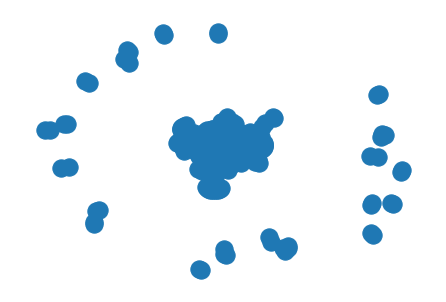

In [ ]:
from pygraphml import GraphMLParser
parser = GraphMLParser()
g = parser.parse(graphml_file)
g.show()

# 네트워크 시도2 (성공)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

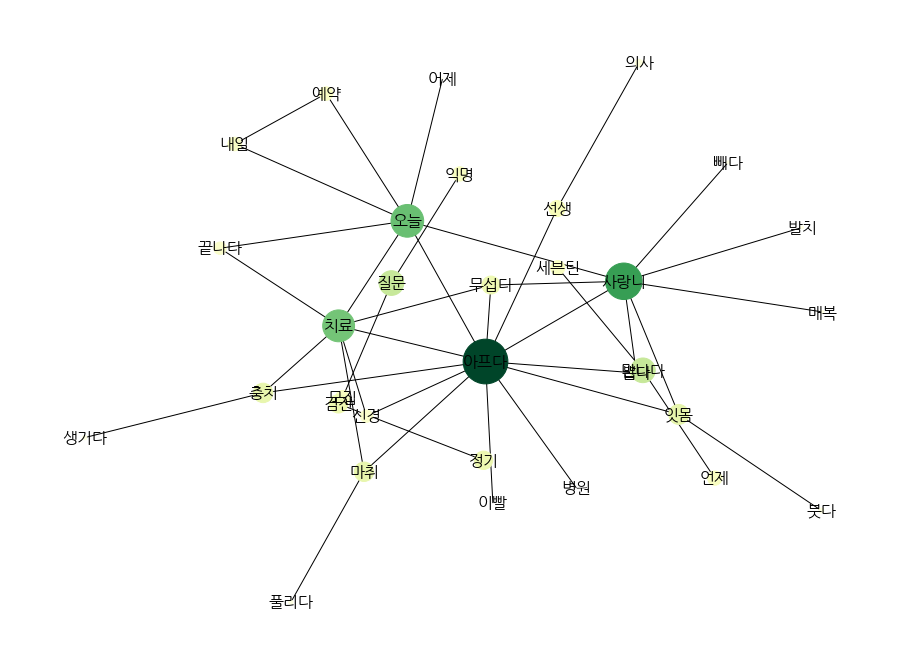

<Figure size 432x288 with 0 Axes>

In [ ]:
G = nx.Graph()
plt.figure(figsize=(16,12))
plt.axis('off') 
G.add_edges_from(df['keyword'])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
# nx.draw_networkx(G, nodelist=d.keys(), node_size=[v*100 for v in d.values()], 
#         font_family='NanumBarunGothic')

#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)

nx.draw_networkx(G, font_family='NanumGothic',font_size=16, pos=pos, node_color = list(pr.values()), node_size=nsize,
                 cmap=plt.cm.YlGn)

plt.show()
plt.savefig("/content/networkGraph.png")

In [ ]:
G.edges()

EdgeView([('병원', '아프다'), ('아프다', '잇몸'), ('아프다', '선생'), ('아프다', '무섭다'), ('아프다', '치료'), ('아프다', '오늘'), ('아프다', '마취'), ('아프다', '이빨'), ('아프다', '신경'), ('아프다', '사랑니'), ('아프다', '충치'), ('아프다', '뽑다'), ('잇몸', '사랑니'), ('잇몸', '붓다'), ('선생', '의사'), ('무섭다', '치료'), ('무섭다', '사랑니'), ('사랑니', '오늘'), ('사랑니', '빼다'), ('사랑니', '매복'), ('사랑니', '뽑다'), ('사랑니', '발치'), ('오늘', '치료'), ('오늘', '어제'), ('오늘', '예약'), ('오늘', '끝나다'), ('오늘', '내일'), ('치료', '끝나다'), ('치료', '신경'), ('치료', '마취'), ('치료', '충치'), ('익명', '질문'), ('질문', '모집'), ('마취', '풀리다'), ('예약', '내일'), ('생기다', '충치'), ('검진', '정기'), ('만나다', '언제'), ('만나다', '세븐틴')])

# 네트워크 시도3 (메트릭스 만들기)

In [162]:
import nltk
from nltk import ConditionalFreqDist
from nltk.util import ngrams

In [164]:
# 단어 제거한 파일 저장 후에 한번더 불러와야 코드 정상작동함 (전처리 부분에 저장코드 있음)
df = pd.read_csv('/content/네트워크만들꺼.csv')

In [165]:
count

,keyword,count
0,오늘,1364
1,치료,1241
2,아프다,1183
3,사랑니,851
4,예약,795
...,...,...
290,일주일,50
291,유치,50
292,영화,50
293,믿다,50


In [166]:
df['cleared_token']

0           ['병원', '달다', '잇몸', '문제', '아프다', '이비인후과']
1                           ['친구', '느낌', '시작', '대기']
2        ['앞니', '유치', '빠지다', '울다', '울다', '뽑다', '뽑다']
3                                ['치료', '다르다', '웃다']
4                           ['학교', '오후', '예약', '환자']
                            ...                     
14159                                             []
14160                                             []
14161                             ['무서워하다', '무서워하다']
14162                                        ['미치다']
14163                                        ['끝나다']
Name: cleared_token, Length: 14164, dtype: object

In [68]:
## 빈문자열 확인 코드
# for li in word_list:
#   if not li:
#     print(li)
#     del li[:]

In [167]:
words = []
bigram = []
token =[]

# 빈 리스트 제거 후에 처리 시작(안하면 token += 부분에서 오류)
df = df.replace('[]',np.nan)
df = df.dropna(how = 'any')

for i in df['cleared_token']:
    #print(i)
    i = ast.literal_eval(i)
    words.append(i)

# # 단어 두 개씩 조합
for word in words:
    #print(word)
    bigrams = ngrams(word,2)
    bigram.append(bigrams)

for i in bigram:
  token += ([x for x in i])

cfd = ConditionalFreqDist(token)
cfd.conditions()

['병원',
 '달다',
 '잇몸',
 '문제',
 '아프다',
 '친구',
 '느낌',
 '시작',
 '앞니',
 '유치',
 '빠지다',
 '울다',
 '뽑다',
 '치료',
 '다르다',
 '학교',
 '오후',
 '예약',
 '시험',
 '끝나다',
 '의사',
 '당장',
 '무섭다',
 '혼자',
 '공포',
 '수술',
 '검진',
 '일정',
 '이름',
 '웃기다',
 '눈물',
 '내일',
 '싫다',
 '아기',
 '데려가다',
 '오늘',
 '사랑니',
 '빼다',
 '마시다',
 '전화',
 '듣다',
 '생기다',
 '예쁘다',
 '사진',
 '웃다',
 '일찍',
 '교정',
 '엄마',
 '오래',
 '돈가스',
 '미치다',
 '묻다',
 '약속',
 '얼굴',
 '아이',
 '작다',
 '참다',
 '출근',
 '버스',
 '깨지다',
 '이빨',
 '상태',
 '좋아하다',
 '괜찮다',
 '기분',
 '새로',
 '힘들다',
 '남다',
 '치통',
 '필요',
 '처음',
 '어리다',
 '싫어하다',
 '올리다',
 '입안',
 '열심히',
 '유지',
 '장치',
 '무서워하다',
 '스케일링',
 '아빠',
 '어금니',
 '물어보다',
 '냄새',
 '시리다',
 '사이',
 '여자',
 '상상',
 '기억',
 '걸리다',
 '일주일',
 '어제',
 '동생',
 '미루다',
 '왼쪽',
 '충치',
 '토요일',
 '치아',
 '진심',
 '빨다',
 '양치',
 '씹다',
 '사랑',
 '썩다',
 '재미있다',
 '추천',
 '매복',
 '불편',
 '산부인과',
 '정신',
 '아침',
 '저녁',
 '확인',
 '진료',
 '공부',
 '벌써',
 '의자',
 '머리',
 '언니',
 '자리',
 '상담',
 '건강검진',
 '모두',
 '질문',
 '항문',
 '챙기다',
 '망하다',
 '관리',
 '자주',
 '피부',
 '바르다',
 '약간',
 '정기',
 '주말',
 '만원',
 '끼다',
 '

In [168]:
len(token)

23723

In [169]:
freq_matrix = []

for i in cfd.keys():
  temp = []
  for j in cfd.keys():
    temp.append(cfd[i][j])
  freq_matrix.append(temp)
freq_matrix = np.array(freq_matrix)

df = pd.DataFrame(freq_matrix, index = cfd.keys(), columns = cfd.keys())
#df.style.background_gradient(cmap='coolwarm')

In [170]:
df

,병원,달다,잇몸,문제,아프다,친구,느낌,시작,앞니,유치,...,씻다,오랜만,돌다,풀다,통증,거리,차다,살리다,졸리다,가능
병원,31,2,1,2,6,1,2,1,0,0,...,0,0,3,0,0,1,1,0,0,1
달다,0,4,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
잇몸,2,0,11,4,27,0,2,1,0,0,...,0,0,0,0,3,0,0,3,0,0
문제,3,0,0,2,2,0,0,0,0,0,...,0,1,1,3,0,0,0,1,0,0
아프다,21,0,14,3,75,2,7,14,1,0,...,1,0,1,0,6,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
거리,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
차다,1,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,1
살리다,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
졸리다,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [171]:
df.to_csv('/content/치과_matrix.csv', encoding = 'utf-8-sig')

### 불필요한 부분

In [ ]:
G = nx.Graph()
G = nx.from_pandas_adjacency(df)
nodes = G.nodes()
len(print(G.nodes()))
len(print(G.edges()))

In [ ]:
G.edges()[('병원', '아프다')]

{'weight': 16}

In [ ]:
edges = G.edges()
weights = [abs(G[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights]

In [ ]:
weights

In [ ]:
plt.figure(figsize=(16,12))
G = nx.Graph()
G = nx.from_pandas_adjacency(df)
pr = nx.pagerank(G)

nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))
# nx.draw_networkx(G, nodelist=d.keys(), node_size=[v*100 for v in d.values()], 
#         font_family='NanumBarunGothic')

#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
pos = nx.kamada_kawai_layout(G)
#pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos=pos,font_family='NanumGothic', nodelist=nodes, 
                       node_size=nsize, cmap=plt.cm.YlGn)
nx.draw_networkx_edges(G, pos=pos,font_family='NanumGothic', width=weights_n)

plt.show()
plt.savefig("/content/networkGraph.png")

# 오류 고친 내용
리스트.remove(요소)로

바로 제거하는 경우

for문 index가 꼬여서 제대로 불용어 등이 제거되지 않음을 확인

In [ ]:
bbb = ['원장', '친구', '환자', '종종', '샤이', '확진', '확진']
ccc = ['원장', '친구', '환자', '확진']
ddd = []
for i, b in enumerate(bbb):
  print(i,b)
  if b in ccc:
    # bbb.remove(b)
    ddd.append(b)
    
print(ddd)
bbb = ['원장', '친구', '환자', '종종', '샤이', '확진', '확진']
s = ['원장', '친구', '환자', '확진']

for b in bbb:
  if b in s:
    bbb.remove(b)

print(bbb)
bbb = ['원장', '친구', '환자', '종종', '샤이', '확진', '확진']
s = ['원장', '친구', '환자', '확진']
sss = []
for b in bbb:
  if b in s:
    bbb.remove(b)

print(bbb)

0 원장
1 친구
2 환자
3 종종
4 샤이
5 확진
6 확진
['원장', '친구', '환자', '확진', '확진']
